In [66]:
import pandas as pd
import glob
import igraph as ig
import numpy as np
import re
from tqdm import tqdm

In [4]:
# Download associations https://platform.opentargets.org/downloads
# wget --recursive --no-parent --no-host-directories --cut-dirs 8 ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/25.03/output/association_by_datasource_direct association_type
data_dir = "../data/open_targets/association_type/"
df = pd.read_parquet(data_dir, engine="pyarrow")
print(df.head())

            datatypeId datasourceId    diseaseId         targetId     score  \
0  genetic_association  gene_burden  EFO_0000095  ENSG00000082898  0.477978   
1  genetic_association  gene_burden  EFO_0000095  ENSG00000115524  0.904151   
2  genetic_association  gene_burden  EFO_0000095  ENSG00000141510  0.660781   
3  genetic_association  gene_burden  EFO_0000095  ENSG00000146232  0.612450   
4  genetic_association  gene_burden  EFO_0000095  ENSG00000148400  0.945168   

   evidenceCount  
0              2  
1             10  
2              4  
3              2  
4             16  


In [5]:
# Remove influence of literature
df = df[df['datatypeId'] != 'literature']
df['datatypeId'].value_counts()

datatypeId
animal_model           655057
genetic_association    472430
rna_expression         160061
somatic_mutation        88137
known_drug              74197
affected_pathway        38103
Name: count, dtype: int64

In [82]:
df

,datatypeId,datasourceId,diseaseId,targetId,score,evidenceCount,weight,weighted_term
0,genetic_association,gene_burden,EFO_0000095,ENSG00000082898,0.477978,2,1.0,0.522022
1,genetic_association,gene_burden,EFO_0000095,ENSG00000115524,0.904151,10,1.0,0.095849
2,genetic_association,gene_burden,EFO_0000095,ENSG00000141510,0.660781,4,1.0,0.339219
3,genetic_association,gene_burden,EFO_0000095,ENSG00000146232,0.612450,2,1.0,0.387550
4,genetic_association,gene_burden,EFO_0000095,ENSG00000148400,0.945168,16,1.0,0.054832
...,...,...,...,...,...,...,...,...
3826176,somatic_mutation,eva_somatic,Orphanet_93271,ENSG00000186638,0.547138,1,1.0,0.452862
3826177,somatic_mutation,eva_somatic,Orphanet_93610,ENSG00000166415,0.744715,3,1.0,0.255285
3826178,somatic_mutation,eva_somatic,Orphanet_93951,ENSG00000149970,0.577534,1,1.0,0.422466
3826179,somatic_mutation,eva_somatic,Orphanet_96210,ENSG00000242866,0.030397,1,1.0,0.969603


In [6]:
weights = {
    "europe_pm": 0.2,
    "expression_atlas": 0.2,
    "impc": 0.2,
    "progeny": 0.5,
    "slapenrich": 0.5,
    "cancer_biomarkers": 0.5,
    "sysbio": 0.5,
    "otar_projects": 0.5,
    "default": 1.0  
}

def get_weight(ds):
    return weights.get(ds, weights['default'])
df['weight'] = df['datatypeId'].apply(get_weight)
print(df)
df['weighted_term'] = 1 - (df['weight'] * df['score'])

def harmonic_sum(group):
    product_term = np.prod(group['weighted_term'])
    return 1 - product_term
final_scores = df.groupby(['diseaseId', 'targetId']).apply(harmonic_sum).reset_index(name='customAssociationScore')


                  datatypeId datasourceId       diseaseId         targetId  \
0        genetic_association  gene_burden     EFO_0000095  ENSG00000082898   
1        genetic_association  gene_burden     EFO_0000095  ENSG00000115524   
2        genetic_association  gene_burden     EFO_0000095  ENSG00000141510   
3        genetic_association  gene_burden     EFO_0000095  ENSG00000146232   
4        genetic_association  gene_burden     EFO_0000095  ENSG00000148400   
...                      ...          ...             ...              ...   
3826176     somatic_mutation  eva_somatic  Orphanet_93271  ENSG00000186638   
3826177     somatic_mutation  eva_somatic  Orphanet_93610  ENSG00000166415   
3826178     somatic_mutation  eva_somatic  Orphanet_93951  ENSG00000149970   
3826179     somatic_mutation  eva_somatic  Orphanet_96210  ENSG00000242866   
3826180     somatic_mutation  eva_somatic  Orphanet_99739  ENSG00000140416   

            score  evidenceCount  weight  
0        0.477978   

/var/folders/2h/45bqs84942sfxfwfndsxtgs40000gn/T/ipykernel_80860/2734564200.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  final_scores = df.groupby(['diseaseId', 'targetId']).apply(harmonic_sum).reset_index(name='customAssociationScore')


In [7]:
# Download from OpenTargets
# wget --recursive --no-parent --no-host-directories --cut-dirs 8 ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/25.03/output/evidence .
# wget --recursive --no-parent --no-host-directories --cut-dirs 8 ftp://ftp.ebi.ac.uk/pub/databases/opentargets/platform/25.03/output/disease .

# file_list = glob.glob("./targets/*.json")
# data_frames_list = [pd.read_json(file,lines="TRUE") for file in file_list]
# combined_targets = pd.concat(data_frames_list, ignore_index=True)
# combined_targets = combined_targets.rename(columns={'id': 'targetId'})
# combined_targets.to_csv("../data/open_targets/gene_map.csv", index=False)

# file_list = glob.glob("./diseases/*.json")
# data_frames_list = [pd.read_json(file,lines="TRUE") for file in file_list]
# combined_disease = pd.concat(data_frames_list, ignore_index=True)
# combined_disease = combined_disease.rename(columns={'id': 'diseaseId'})
# combined_disease.to_csv("../data/open_targets/disease_map.csv", index=False)

combined_disease = pd.read_csv("../data/open_targets/disease_map.csv")
combined_disease.columns
combined_disease = combined_disease[["diseaseId","name"]]

combined_targets = pd.read_csv("../data/open_targets/gene_map.csv")
combined_targets.columns
combined_targets = combined_targets[["targetId","approvedSymbol"]]

In [24]:
display(combined_disease.head(5))
display(combined_targets.head(5))

,diseaseId,name
0,EFO_0001073,obesity
1,EFO_0003105,spina bifida
2,EFO_0003812,refractory anemia with ringed sideroblasts
3,EFO_0004238,hearing loss
4,EFO_0004586,complete blood cell count


,targetId,approvedSymbol
0,ENSG00000007202,BLTP2
1,ENSG00000011260,UTP18
2,ENSG00000064489,BORCS8-MEF2B
3,ENSG00000064655,EYA2
4,ENSG00000064703,DDX20


In [13]:
disease_edge = pd.merge(final_scores, combined_disease, on = "diseaseId")
disease_edge = pd.merge(disease_edge, combined_targets, on = 'targetId')
disease_edge = disease_edge[["name","approvedSymbol","customAssociationScore"]]
# disease_edge.to_csv("gene_association_edge_list_no_lit.csv.gzip", compression="gzip", index=False)
# disease_edge = pd.read_csv("gene_association_edge_list_no_lit.csv")

In [69]:
measurement_keywords = ['measurement', 'level', 'concentration', 'trait',
                        'response', 'ratio', 'presence', 'status', 'microdeletion', 
                        'microduplication']#, 'deletion', 'duplication']
    
# Assuming disease_edge is your DataFrame
pattern = '|'.join(measurement_keywords)  # Create regex pattern

# Filter out rows where 'name' contains any of the keywords (case-insensitive)
disease_edge_filtered = disease_edge[~disease_edge['name'].str.contains(pattern, case=False, na=False)]
disease_edge_filtered

,name,approvedSymbol,customAssociationScore
0,trypanosomiasis,GABRA3,0.060793
1,trypanosomiasis,GABRA1,0.060793
2,trypanosomiasis,APOL1,0.607931
3,trypanosomiasis,GABRG2,0.060793
4,trypanosomiasis,FGF1,0.531939
...,...,...,...
1425154,Autosomal dominant Charcot-Marie-Tooth disease...,MBP,0.278615
1425155,Autosomal dominant Charcot-Marie-Tooth disease...,OPA1,0.281533
1425156,Autosomal dominant Charcot-Marie-Tooth disease...,LTN1,0.289801
1425157,Autosomal dominant Charcot-Marie-Tooth disease...,MYH4,0.250346


In [71]:
disease_edge_target = disease_edge_filtered.pivot_table(index = "approvedSymbol",columns = "name",values = "customAssociationScore",aggfunc = "mean")
disease_edge_target = disease_edge_target.fillna(0)
disease_edge_target

name,15q overgrowth syndrome,"17,20-lyase deficiency, isolated","17-alpha-hydroxylase/17,20-lyase deficiency, combined complete","17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",2-3 finger syndactyly,2-3 toe syndactyly,2-aminoadipic 2-oxoadipic aciduria,2-hydroxyglutaric aciduria,2-methylbutyryl-CoA dehydrogenase deficiency,3-4 toe syndactyly,...,xeroderma pigmentosum group G,xeroderma pigmentosum variant type,xeroderma pigmentosum-Cockayne syndrome complex,xerosis and growth failure with immune and pulmonary dysfunction syndrome,xerostomia,young-onset Parkinson disease,zebra body myopathy,"zinc deficiency, transient neonatal",zygodactyly type 3,Åland Islands eye disease
approvedSymbol,,,,,,,,,,,,,,,,,,,,,
7SK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1BG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A2M-AS1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZYG11A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYG11B,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZYX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
# Edge between diseases in disaese-disease matrix is calculated as Pearson correlation between their gene vectors
data = disease_edge_target.to_numpy()
correlations = np.corrcoef(data, rowvar=False)  # rowvar=False means columns are variables

In [73]:
#  Bray-Curtis dissimilarity (e.g., sum of min over shared genes)
# More computationally expensive, but more biologically interpretable
# Bray, J. R., & Curtis, J. T. (1957). An ordination of the upland forest communities of southern Wisconsin. Ecological Monographs, 27(4), 325–349.
# Lozupone, C. A., & Knight, R. (2005). UniFrac: a new phylogenetic method for comparing microbial communities. Applied and Environmental Microbiology, 71(12), 8228–8235.

# diseases = disease_edge_target.columns
# adj_matrix_min = pd.DataFrame(0.0, index=diseases, columns=diseases)

# for i in tqdm(range(len(diseases)), desc="Computing min adjacency"):
#     for j in range(i, len(diseases)):
#         d1, d2 = diseases[i], diseases[j]
#         shared_min = np.minimum(disease_edge_target[d1], disease_edge_target[d2]).sum()
#         adj_matrix_min.loc[d1, d2] = shared_min
#         adj_matrix_min.loc[d2, d1] = shared_min  # symmetric


In [74]:
correlations = pd.DataFrame(
    correlations,
    index=disease_edge_target_small_wide.columns,
    columns=disease_edge_target_small_wide.columns
)
correlations.head()

name,15q overgrowth syndrome,"17,20-lyase deficiency, isolated","17-alpha-hydroxylase/17,20-lyase deficiency, combined complete","17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",2-3 finger syndactyly,2-3 toe syndactyly,2-aminoadipic 2-oxoadipic aciduria,2-hydroxyglutaric aciduria,2-methylbutyryl-CoA dehydrogenase deficiency,3-4 toe syndactyly,...,xeroderma pigmentosum group G,xeroderma pigmentosum variant type,xeroderma pigmentosum-Cockayne syndrome complex,xerosis and growth failure with immune and pulmonary dysfunction syndrome,xerostomia,young-onset Parkinson disease,zebra body myopathy,"zinc deficiency, transient neonatal",zygodactyly type 3,Åland Islands eye disease
name,,,,,,,,,,,,,,,,,,,,,
15q overgrowth syndrome,1.000000,-0.000143,-0.000143,-0.000143,-0.000181,-0.000282,-0.000683,-0.000143,-0.000230,-0.000143,...,0.037565,-0.000178,-0.000281,-0.000143,-0.000296,-0.000692,-0.001501,-0.001016,-0.000143,-0.000457
"17,20-lyase deficiency, isolated",-0.000143,1.000000,1.000000,1.000000,-0.000047,-0.000073,-0.000176,-0.000037,-0.000059,-0.000037,...,-0.000240,-0.000046,-0.000073,-0.000037,-0.000076,-0.000179,-0.000388,-0.000263,-0.000037,-0.000118
"17-alpha-hydroxylase/17,20-lyase deficiency, combined complete",-0.000143,1.000000,1.000000,1.000000,-0.000047,-0.000073,-0.000176,-0.000037,-0.000059,-0.000037,...,-0.000240,-0.000046,-0.000073,-0.000037,-0.000076,-0.000179,-0.000388,-0.000263,-0.000037,-0.000118
"17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",-0.000143,1.000000,1.000000,1.000000,-0.000047,-0.000073,-0.000176,-0.000037,-0.000059,-0.000037,...,-0.000240,-0.000046,-0.000073,-0.000037,-0.000076,-0.000179,-0.000388,-0.000263,-0.000037,-0.000118
2-3 finger syndactyly,-0.000181,-0.000047,-0.000047,-0.000047,1.000000,-0.000092,-0.000222,-0.000047,-0.000075,-0.000047,...,-0.000302,-0.000058,-0.000092,-0.000047,-0.000096,-0.000226,0.060344,-0.000331,-0.000047,-0.000149


In [75]:
cor_df = correlations.apply(pd.to_numeric)
np.fill_diagonal(cor_df.values, 0)
cor_df[cor_df < 0] = 0
x = np.quantile(np.abs(cor_df.values.flatten()), 0.95)
cor_df[cor_df < x] = 0
cor_df.head()

name,15q overgrowth syndrome,"17,20-lyase deficiency, isolated","17-alpha-hydroxylase/17,20-lyase deficiency, combined complete","17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",2-3 finger syndactyly,2-3 toe syndactyly,2-aminoadipic 2-oxoadipic aciduria,2-hydroxyglutaric aciduria,2-methylbutyryl-CoA dehydrogenase deficiency,3-4 toe syndactyly,...,xeroderma pigmentosum group G,xeroderma pigmentosum variant type,xeroderma pigmentosum-Cockayne syndrome complex,xerosis and growth failure with immune and pulmonary dysfunction syndrome,xerostomia,young-onset Parkinson disease,zebra body myopathy,"zinc deficiency, transient neonatal",zygodactyly type 3,Åland Islands eye disease
name,,,,,,,,,,,,,,,,,,,,,
15q overgrowth syndrome,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
"17,20-lyase deficiency, isolated",0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
"17-alpha-hydroxylase/17,20-lyase deficiency, combined complete",0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
"17-alpha-hydroxylase/17,20-lyase deficiency, combined partial",0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2-3 finger syndactyly,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.060344,0.0,0.0,0.0


In [ ]:
# Remove rows with all zeros
cor_df = cor_df.loc[~(cor_df == 0).all(axis=1)]

# Remove columns with all zeros
cor_df = cor_df.loc[:, ~(cor_df == 0).all(axis=0)]

In [79]:
columns_with_1 = cor_df.columns[(cor_df == 1.0).any()]

# Print those columns
print((cor_df[columns_with_1].columns))

Index(['17,20-lyase deficiency, isolated',
       '17-alpha-hydroxylase/17,20-lyase deficiency, combined complete',
       '17-alpha-hydroxylase/17,20-lyase deficiency, combined partial',
       '3-4 toe syndactyly', '3-Methylglutaric aciduria',
       '3-methylglutaconic aciduria with cataracts, neurologic involvement, and neutropenia',
       'A20 haploinsufficiency', 'ABCA4-related retinopathy',
       'ABeta amyloidosis, Arctic type', 'ABetaA21G amyloidosis',
       ...
       'vitamin B12-responsive methylmalonic acidemia, type cblDv2',
       'vitamin D-dependent rickets, type 2', 'vitelliform macular dystrophy',
       'von Willebrand disease type 2A', 'von Willebrand disease type 2B',
       'von Willebrand disease type 2M', 'von Willebrand disease type 2N',
       'x-linked warfarin sensitivity', 'xanthinuria', 'zygodactyly type 3'],
      dtype='object', name='name', length=902)


Percentage of zeros: 94.99%


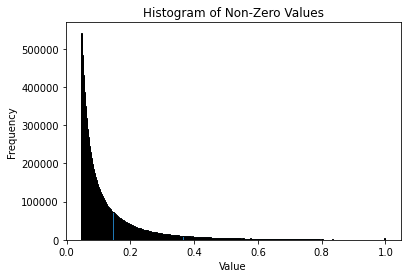

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Flatten DataFrame values to 1D array
all_values = cor_df.values.flatten()

# Count zeros and non-zeros
total_values = len(all_values)
zero_count = np.count_nonzero(all_values == 0)
non_zero_values = all_values[all_values != 0]

# Calculate percentage of zeros
zero_percentage = (zero_count / total_values) * 100
print(f"Percentage of zeros: {zero_percentage:.2f}%")

# Plot histogram of non-zero values
plt.hist(non_zero_values, bins=300, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Non-Zero Values')
plt.show()


In [64]:
cor_df.to_csv("../data/open_targets/cor_matrix_95_nolit.csv", index=False)

In [49]:
for col in cor_df.columns:
    if 'lzh' in col:
        print(col)

Alzheimer disease
Alzheimer disease 18
Alzheimer disease 3
Alzheimer disease type 1
Alzheimer's disease neuropathologic change
age of onset of Alzheimer disease
early-onset autosomal dominant Alzheimer disease
familial Alzheimer disease
family history of Alzheimer’s disease
late-onset Alzheimers disease


In [63]:
# Generate disease modules
def create_disease_module(df, disease_name, output_file):
    disease_col = df.loc[:, disease_name]
    top_20 = (
        disease_col.sort_values(ascending=False)
        .head(20)
    )
    display(top_20)
    pd.DataFrame(top_20.index).to_csv(output_file, index=False)

create_disease_module(cor_df, "Alzheimer disease", "../data/open_targets/ad_cor_20_no_lit.csv")
create_disease_module(cor_df, "childhood cancer", "../data/open_targets/childhoodcancer_cor_20_no_lit.csv")
create_disease_module(cor_df, "congenital heart disease", "../data/open_targets/chd_cor_20_no_lit.csv")

name
Parkinson disease                        0.739253
lysosomal storage disease                0.709381
multiple sclerosis                       0.687098
polygenic risk score                     0.318300
neurodegenerative disease                0.289255
Dementia                                 0.247351
family history of Alzheimer’s disease    0.232589
neuroinflammatory disorder               0.229831
schizoaffective disorder                 0.197127
late-onset Alzheimers disease            0.184979
schizophrenia                            0.181444
Cognitive impairment                     0.169687
depressive disorder                      0.169549
dementia                                 0.162336
delirium                                 0.160479
post-operative sign or symptom           0.154135
pain                                     0.152318
bipolar disorder                         0.150946
obesity                                  0.147595
treatment resistant depression           0.14

name
major salivary gland cancer                                    0.939302
small intestine lymphoma                                       0.614396
Blast Phase Chronic Myelogenous Leukemia, BCR-ABL1 Positive    0.602049
core binding factor acute myeloid leukemia                     0.508395
nephrogenic fibrosing dermopathy                               0.484955
central nervous system leukemia                                0.481484
lymphoid leukemia                                              0.456604
adult glioblastoma                                             0.448029
refractory hairy cell leukemia                                 0.408844
diffuse intrinsic pontine glioma                               0.398142
loiasis                                                        0.378596
chronic myelogenous leukemia                                   0.340391
fibromatosis                                                   0.329704
Pineoblastoma                                              

name
Abnormal heart morphology                                       0.499012
scimitar syndrome                                               0.484181
right atrial isomerism                                          0.460492
visceral heterotaxy                                             0.450829
congenital heart defects, multiple types, 6                     0.446368
tricuspid atresia                                               0.429050
Heterotaxia                                                     0.428191
heterotaxy, visceral, 12, autosomal                             0.423864
hypoplastic left heart syndrome                                 0.423560
atrial septal defect, ostium primum type                        0.423502
atrial septal defect 1                                          0.423022
persistent truncus arteriosus                                   0.420995
Truncus arteriosus                                              0.420755
Congenitally uncorrected transposition of the 

In [ ]:
# Run CTD-ID
# python Python/main_gba.py --adj_path data/open_targets/cor_matrix_95_nolit.csv --s_nodes data/open_targets/ad_cor_20_no_lit.csv -o data/open_targets/results
# python Python/main_gba.py --adj_path data/open_targets/cor_matrix_95_nolit.csv --s_nodes data/open_targets/childhoodcancer_cor_20_no_lit.csv -o data/open_targets/results
# python Python/main_gba.py --adj_path data/open_targets/cor_matrix_95_nolit.csv --s_nodes data/open_targets/chd_cor_20_no_lit.csv -o data/open_targets/results